In [155]:
import pandas as pd
import xarray as xr
import numpy as np
import scipy.interpolate
from netCDF4 import Dataset
import bottleneck
import pyarrow
import scipy.ndimage as ndimage
import geopandas

import matplotlib.pyplot as plt

# Reading in the Data

In [156]:
# Import Merged Data from Notebook in Cloud
data = pd.read_parquet('../../finalproj_data/ds_df.parquet', engine = 'pyarrow')

In [160]:
data.shape

(1034376, 50)

In [157]:
data.head()

,lat,lon,firemask,MaxFRP,gaugeQualityInfo,hourlyPrecipRate,hourlyPrecipRateGC,observationTimeFlag,satelliteInfoFlag,Albedo_inst,...,Swnet_tavg,Tair_f_inst,Tveg_tavg,Wind_f_inst,BurnDate,Uncertainty,QA,FirstDay,LastDay,FWI
0,-4.98565,106.360530,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,-4.98565,106.405485,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,-4.98565,106.450441,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,-4.98565,106.495396,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,-4.98565,106.540352,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [161]:
data.columns

Index(['lat', 'lon', 'firemask', 'MaxFRP', 'gaugeQualityInfo',
       'hourlyPrecipRate', 'hourlyPrecipRateGC', 'observationTimeFlag',
       'satelliteInfoFlag', 'Albedo_inst', 'AvgSurfT_inst', 'CanopInt_inst',
       'ECanop_tavg', 'ESoil_tavg', 'Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg',
       'PotEvap_tavg', 'Psurf_f_inst', 'Qair_f_inst', 'Qg_tavg', 'Qh_tavg',
       'Qle_tavg', 'Qs_acc', 'Qsb_acc', 'Qsm_acc', 'Rainf_f_tavg',
       'RootMoist_inst', 'SWE_inst', 'SWdown_f_tavg', 'SnowDepth_inst',
       'Snowf_tavg', 'SoilMoi100_200cm_inst', 'SoilMoi10_40cm_inst',
       'SoilMoi40_100cm_inst', 'SoilTMP0_10cm_inst', 'SoilMoi0_10cm_inst',
       'SoilTMP100_200cm_inst', 'SoilTMP10_40cm_inst', 'SoilTMP40_100cm_inst',
       'Swnet_tavg', 'Tair_f_inst', 'Tveg_tavg', 'Wind_f_inst', 'BurnDate',
       'Uncertainty', 'QA', 'FirstDay', 'LastDay', 'FWI'],
      dtype='object')

In [162]:
# Drop columns that were not deemed important features
less_than_onepercent = ['EVI',
 'EVI2',
 'NVDI',
 'NIR_reflectance',
 'SWIR1_reflectance',
 'SWIR2_reflectance',
 'composite_day_of_the_year',
 'green_reflectance',
 'red_reflectance',
 'relative_azimuth_angle',
 'sun_zenith_angle',
 'view_zenith_angle',
 'gaugeQualityInfo',
 'observationTimeFlag',
 'satelliteInfoFlag',
 'ECanop_tavg',
 'Qg_tavg',
 'Qh_tavg',
 'Qs_acc',
 'Qsm_acc',
 'SWE_inst',
 'SWdown_f_tavg',
 'SnowDepth_inst',
 'Snowf_tavg',
 'SoilMoi40_100cm_inst',
 'SoilTMP10_40cm_inst',
 'Tveg_tavg',
 'Uncertainty']

d.drop(less_than_onepercent, axis = 1, inplace = True)

# Exploring the Data

In [163]:
d = data.astype('float')

In [164]:
d['firemask'].value_counts()

3.0    360887
5.0    339477
4.0     87932
9.0        81
8.0        57
6.0        19
7.0        16
Name: firemask, dtype: int64

In [165]:
# d.info()

In [166]:
# MAJOR ASSUMPTION: Fill all nulls with 0
d.fillna(0, inplace = True)

## Transform into GeoDataFrame

In [167]:
d = geopandas.GeoDataFrame(d, geometry=geopandas.points_from_xy(d.lon, d.lat))

# Create Target Categories

In [168]:
# Start with all the values in FireMask
d['label'] = d['firemask']

In [169]:
d['label'].value_counts()

3.0    360887
5.0    339477
0.0    245907
4.0     87932
9.0        81
8.0        57
6.0        19
7.0        16
Name: label, dtype: int64

In [170]:
# Create categorical values for active fire pixels
# FireMask
# 3 = water, non-fire
# 4 = cloud (land or water)
# 5 = land, non-fire
# 6 = unknown (land or water)
# 7, 8, 9 = fire (low, nominal and high confidence)

d.loc[d['firemask'] == 3, 'label'] = 'water'
d.loc[d['firemask'] == 5, 'label'] = 'land'
d.loc[(d['firemask'] == 9) | (d['firemask'] == 8) | (data['firemask'] == 7), 'label'] = 'active_fire'

# 4, 6, and zero are unknown right now - we will fill those in later. 
d.loc[d['firemask'] == 0, 'label'] = 'unknown'
d.loc[d['firemask'] == 4, 'label'] = 'unknown'
d.loc[d['firemask'] == 6, 'label'] = 'unknown'

In [171]:
# If last day of burn is earlier than December 21 (day 344), mark as burned
d.loc[(d['LastDay'] > 344), 'label'] = 'burned'

# If last day of burn is day 344 - 345, mark as active fire
d.loc[((d['LastDay'] >= 344) & (d['LastDay'] <= 345)), 'label'] = 'active_fire'

# If last day of burn is after day 346, mark as land
# we will later delete these burned columns, so they will not distort the time dimension of the dataset
d.loc[(d['LastDay'] > 345), 'label'] = 'land'

In [172]:
# Using the other datasets, let's determine whether unknown pixels are land or water

# if the pixel has a starting burn date, we know it is land
d.loc[((d['label']=='unknown') & (d['FirstDay'] > 0)), 'label'] = 'land'

# If there is a FWI value for the pixel, it is land
d.loc[(d['label']=='unknown') & (d['FWI'] >0), 'label'] = 'land'

In [179]:
d['label'].value_counts()

land           395122
water          356951
unknown        279798
active_fire      2505
Name: label, dtype: int64

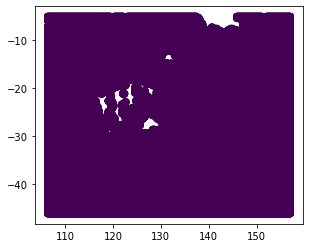

In [145]:
d.loc[(d['label']=='unknown') & (d['Evap_tavg']< 0.00002), 'untitled'] = 1

In [152]:
d['untitled'] = 1

In [180]:
# Get coordinates for unknown values and plot on google earth engine
unknown_coords = d.loc[(d['label']=='unknown'), ['lat', 'lon', 'untitled']]

In [181]:
unknown_coords.to_csv('../../finalproj_data/unknown.csv')

In [99]:
d.loc[d['label']=='water', 'ESoil_tavg'].value_counts()

0.000000     352414
1.250000         41
4.115000         31
1.280000         31
0.295000         30
              ...  
30.494999         1
15.255000         1
10.775000         1
25.404999         1
4.750000          1
Name: ESoil_tavg, Length: 719, dtype: int64

In [74]:
d['label'].value_counts()

land           370721
water          356951
unknown        304199
active_fire      2505
Name: label, dtype: int64

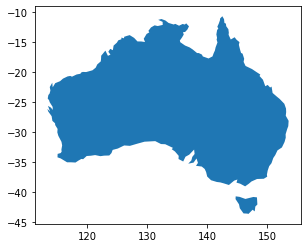

In [128]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
aus = world[world['name']=='Australia']
aus.plot()

0.0      241848
293.0        36
292.0        35
297.0        28
291.0        27
329.0        22
327.0        20
294.0        14
299.0        14
308.0        13
320.0        12
290.0        11
325.0        11
304.0        10
331.0         9
283.0         8
306.0         8
296.0         7
300.0         7
282.0         7
334.0         7
284.0         7
295.0         7
298.0         7
316.0         6
301.0         5
287.0         5
333.0         5
285.0         4
318.0         4
289.0         4
302.0         4
322.0         3
328.0         3
330.0         3
323.0         3
326.0         2
310.0         2
332.0         2
324.0         2
288.0         2
286.0         2
336.0         2
311.0         2
338.0         2
314.0         1
312.0         1
313.0         1
Name: FirstDay, dtype: int64

In [22]:
# For "land" areas, create categorical values from FWI numerical

d.loc[(d['FWI'] < 5) & (d['label'] == 'land'), 'label'] = 'fwi_low'
d.loc[(d['FWI'] >= 5) & (d['FWI'] < 8) & (d['label'] == 'land'), 'label'] = 'fwi_moderate'
d.loc[(d['FWI'] >= 8) & (d['FWI'] < 16) & (d['label'] == 'land'), 'label'] = 'fwi_high'
d.loc[(d['FWI'] >= 16) & (d['FWI'] < 29) & (d['label'] == 'land'), 'label'] = 'fwi_veryhigh'
d.loc[(d['FWI'] >= 29) & (d['label'] == 'land'), 'label'] = 'fwi_extreme'

In [27]:
d.loc[(d['label'] == 5), 'label'] = d.loc[(d['label'] == 5), 'FWI']
d.loc[d['label'] == 4, 'label'] = d.loc[d['label'] == 4, 'FWI']
d.loc[d['label'] == 6, 'label'] = d.loc[d['label'] == 6, 'FWI']

In [29]:

d.loc[((d['BurnDate'] > 0) & (d['firemask']==4)), 'label'] = 'burned'

In [30]:
d['label'].value_counts()

fwi_low         582175
water           383783
fwi_extreme      30481
fwi_high         14398
fwi_veryhigh     13382
fwi_moderate      7733
burned            2231
active_fire        193
Name: label, dtype: int64

In [32]:
d.loc[(d['label'] ==0) | (d['label'].isna())]

,lat,lon,firemask,MaxFRP,EVI,EVI2,NVDI,NIR_reflectance,SWIR1_reflectance,SWIR2_reflectance,...,Tair_f_inst,Tveg_tavg,Wind_f_inst,BurnDate,Uncertainty,QA,FirstDay,LastDay,FWI,label


In [247]:
# # Create categorical values for burned pixels, only for areas that are not active fire
# # burned
# # 0.0 = unburned
# # -2.0 = water

# data.loc[(data['burned'] != 0.) & (data['burned'] != -2.) & (data['label'] != 'active_fire'), 'label'] = 'burned'

In [251]:
# # for missing data from viirs - i.e. cloud and unknown pixels, fill in missing information from categories in burned dataset

# # for cloud pixels...
# # where 'unburned', code as land
# data.loc[(data['label'] == 4) & (data['burned'] == 0), 'label'] = 'land'
# # where 'water', code as water
# data.loc[(data['label'] == 4) & (data['burned'] == -2.), 'label'] = 'water'                              
                                 

# # for unknown pixels...
# # where unburned, code as land
# data.loc[(data['label'] == 6) & (data['burned'] == 0), 'label'] = 'land'
# # where 'water', code as water
# data.loc[(data['label'] == 6) & (data['burned'] == -2.), 'label'] = 'water'    

# Drop columns that were used to create labels

In [33]:
d.columns

Index(['lat', 'lon', 'firemask', 'MaxFRP', 'EVI', 'EVI2', 'NVDI',
       'NIR_reflectance', 'SWIR1_reflectance', 'SWIR2_reflectance',
       'SWIR3_reflectance', 'VI_Quality', 'blue_reflectance',
       'composite_day_of_the_year', 'green_reflectance', 'pixel_reliability',
       'red_reflectance', 'relative_azimuth_angle', 'sun_zenith_angle',
       'view_zenith_angle', 'gaugeQualityInfo', 'hourlyPrecipRate',
       'hourlyPrecipRateGC', 'observationTimeFlag', 'satelliteInfoFlag',
       'Albedo_inst', 'AvgSurfT_inst', 'CanopInt_inst', 'ECanop_tavg',
       'ESoil_tavg', 'Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg',
       'PotEvap_tavg', 'Psurf_f_inst', 'Qair_f_inst', 'Qg_tavg', 'Qh_tavg',
       'Qle_tavg', 'Qs_acc', 'Qsb_acc', 'Qsm_acc', 'Rainf_f_tavg',
       'RootMoist_inst', 'SWE_inst', 'SWdown_f_tavg', 'SnowDepth_inst',
       'Snowf_tavg', 'SoilMoi100_200cm_inst', 'SoilMoi10_40cm_inst',
       'SoilMoi40_100cm_inst', 'SoilTMP0_10cm_inst', 'SoilMoi0_10cm_inst',
       'SoilTMP100

In [34]:
# Create smaller dataset for first model run
newdata_v1 = d.drop(['firemask', 'BurnDate', 'FirstDay', 'LastDay', 'FWI'], axis = 1)

In [35]:
# Export data as clean parquet gzip file
newdata_v1.to_parquet('../../finalproj_data/input_data/newdata_v1.parquet')

In [36]:
newdata_v1['label'].value_counts()

fwi_low         582175
water           383783
fwi_extreme      30481
fwi_high         14398
fwi_veryhigh     13382
fwi_moderate      7733
burned            2231
active_fire        193
Name: label, dtype: int64